#### Imports

In [4]:
import numpy as np
import scipy.optimize
import matplotlib.pylab as plt
%matplotlib inline

# Homework 4: robotic navigation

**Preamble**: You have built a robot for navigating in an indoor environment. The environments you consider have flat floors, so that the whole task is always two-dimensional. The robot has a sensing capability, as it can sense a location with respect to special beacons. You have given a robot to a friend, who uses it to map different interiors. To do the mapping, your friend places beacons at the perimeter of the interior, and then moves the robot through some trajectory.
Every so often the robot stops, uses its compass to align itself with the direction to the north and then tries to sense the location of the beacons (relative to the robot's current position). Typically, it manages to locate several closest beacons. Your friend has conducted three experiments in three different interiors. You need to recover the location of beacons and the locations of the robot (where the measurements have been taken). 
From each experiment you get four arrays of measurements: **'beacons', 'robots', 'x', 'y'**. It is interpreted as follows: while the robot is in the position number **'robots[i]'**, it senses the beacon number 'beacons(i)', and the beacon is displaced by **'x[i]'** and **'y[i]'** from the robot's position. For each robot position, the robot senses several beacons. This data should be sufficient to recover the positions of the robot and of the beacons (up to a global translation, that does not matter for the purposes of your friend). 

**Experiment one (task1.mat) - 1 point:** This is the simplest environment (a room with a simple shape), the robot sensor works well (although a certain amount of Gaussian noise is present). The reconstruction can be reduced to solving a simple least-squares problem. Hint: use linear least-squares. Avoid using the explicit inversion of matrix. Instead, use *numpy.linalg.lstsq* to solve equations. Note that *numpy.linalg.lstsq* might add a (small) regularization to the system. Try using inversion (*'numpy.linalg.inv'*) to see how the reconstruction performs without regularization.


### Solution Exp 1

Our goal is to find radius-vector of every robot's position $i$: $r^r_i = [x^r_i, y^r_i$] and every beacons' location $j: r^b_j = [x^b_i, y^b_i]$.

We have $r^i_j = [x^i_j, y^i_j]$ - distance between robot $i$ and beacon $j$. $\epsilon$ - Gaussian noise.

The vector equation is 
$$r^r_i + r^i_j = r^b_j + \epsilon$$ 
$$r^r_i - r^b_j + \mathbf{r^i_j} = \epsilon$$
The bold ones we know and the others can be rewritten as a multiplication of coefficients matrix $A$ and vector of coordinates $v = r^r_i - r^b_j + r^i_j$. Then, for each coordinates the least-squares can be applied.
$$
\sum\limits_{\substack{k\\i=robot[k]\\j=beacon[k]}}\| r^r_i - r^b_j + r^i_j|_2^2\to \min\limits_{r^r_i, r^b_j}
$$



In [5]:
import scipy.io as sio

mat_contents = sio.loadmat('task1.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

In [8]:
def FindLocations(beacons, robots, x, y, solver):
    nmb_robots = robots.max()
    nmb_beacons = beacons.max()
    nmb_measurements = len(x)

    A_r = np.zeros((nmb_measurements, nmb_robots))
    A_b = np.zeros((nmb_measurements, nmb_beacons))
    A_r[np.arange(nmb_measurements), robots.ravel() - 1] =  -1
    A_b[np.arange(nmb_measurements), beacons.ravel() - 1] = 1
    
    A = np.hstack((A_b, A_r))

    v = solver(A, x)[0]
    beacons_x = v[:nmb_beacons]
    robots_x = v[nmb_beacons:]

    v = solver(A, y)[0]
    beacons_y = v[:nmb_beacons]
    robots_y = v[nmb_beacons:]

    return beacons_x, robots_x, beacons_y, robots_y

In [12]:
def FindLocations(beacons, robots, x, y, solver):
    
    nmb_measurements = len(x)
    nmb_robots = robots.max()
    nmb_beacons = beacons.max()
    
    A_r = np.zeros((nmb_measurements, nmb_robots))
    A_b = np.zeros((nmb_measurements, nmb_beacons))
    A_r[np.arange(nmb_measurements), robots.ravel() - 1] =  1
    A_b[np.arange(nmb_measurements), beacons.ravel() - 1] = - 1
    
    A = np.hstack((A_b, A_r))
    A = np.array(np.bmat([[A, np.zeros(A.shape)], [np.zeros(A.shape), A]]))
    
    
    v = solver(A, np.vstack((x, y)))[0].ravel()
    
    beacons_x, robots_x, beacons_y, robots_y, zero = np.split(v, np.cumsum([nmb_beacons, nmb_robots] * 2))

    return beacons_x, robots_x, beacons_y, robots_y



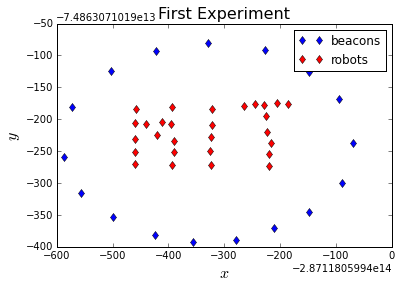

In [9]:
beacons_x, robots_x, beacons_y, robots_y = FindLocations(beacons, robots, x, y, solver = np.linalg.lstsq)

plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('First Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)

plt.show()



#### Without regularization

The result is not successful because $A^\mathsf{T}A$ is singular.

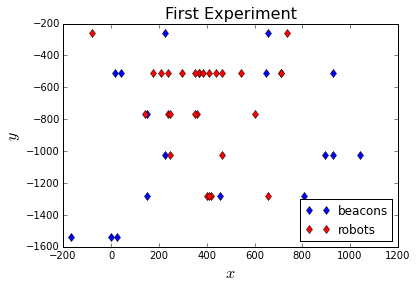

In [10]:
beacons_x, robots_x, beacons_y, robots_y = FindLocations(beacons, robots, x, y,
                                        solver=lambda A, x: [np.linalg.inv(A.T.dot(A)).dot(A.T.dot(x))])

plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('First Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)

plt.show()



** Experiment two (task2.mat) - 4 points: ** This is a more complex environment. On top of that, there are strong electrical currents under the floor, so that the compass on the robot makes significant errors, so that the robot is not perfectly oriented. Thus, in addition to robot positions you would also need to recover robot orientations. *Hint and instructions:* you can still try to solve the problem as if the robot is perfectly oriented. You can then use what you obtain as an initialization to the non-linear initialization (angles can be initialized at zero). For the non-linear optimization, you should use non-linear least-squares. You can then either code Levenberg-Marquardt method yourself or figure out how to use *'scipy.optimize'*. In the latter case, to get the points, your final version must provide the python's routine with a Jacobian computed (analytically) by your code.


In [13]:
import scipy.io as sio

mat_contents = sio.loadmat('task2.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']


### Solution Exp 2
#### 1. Robot is perfectly oriented

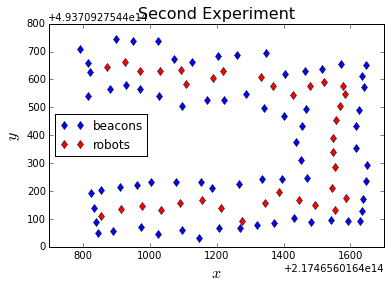

In [14]:
beacons_x, robots_x, beacons_y, robots_y = FindLocations(beacons, robots, x, y, solver = np.linalg.lstsq)

plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('Second Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)

plt.show()


#### 2. Non-linear least-squares

Now there are problems with robots navigations and let's assume that the orientation angle to the horizon in robot position $i$ is $\phi_i$. Then for each axis we will have
$$
x^r_i - x^b_j + x^i_j\cos\phi_i - y^i_j\sin\phi_{i} = \epsilon
$$$$
y^r_i - y^b_j + x^i_j\sin\phi_{i} + y^i_j\cos\phi_i = \epsilon
$$
And in the perfect orientation case it will be the same to  

$$
x^r_i - x^b_j + x^i_j = \epsilon
$$$$
y^r_i - y^b_j + y^i_j = \epsilon
$$

Then, we have functions:
$$
f_x = x^r_i - x^b_j + x^i_j\cos\phi_i - y^i_j\sin\phi_{i} 
$$$$
f_y = y^r_i - y^b_j + x^i_j\sin\phi_{i} + y^i_j\cos\phi_i,
$$
which we use to calculate gradients for Jacobian and use scipy.optimize

In [15]:

def LevenbergMarquardt(beacons, robots, x, y):
    
    nmb_robots = robots.max()
    nmb_angles = robots.max()
    nmb_beacons = beacons.max()
    nmb_measurements = len(x)
    
    
    robots = robots.ravel() - 1
    beacons = beacons.ravel() - 1
    
    A_r = np.zeros((nmb_measurements, nmb_robots))
    A_b = np.zeros((nmb_measurements, nmb_beacons))
    A_r[np.arange(nmb_measurements), robots] =  1 # we have 1 in gradient for robots
    A_b[np.arange(nmb_measurements), beacons] = -1 # we have -1 in gradient for beacons

    A = np.hstack((A_b, A_r))
    A = np.array(np.bmat([[A, np.zeros(A.shape)], [np.zeros(A.shape), A]]))
    v = np.linalg.lstsq(A, - np.vstack((x, y)))[0]

    x = x.ravel()
    y = y.ravel()

    initialization = np.hstack((v.ravel(), np.zeros(nmb_angles)))

    def fun(z):
        beacons_x, robots_x, beacons_y, robots_y, angles = np.split(z, np.cumsum([nmb_beacons, nmb_robots] * 2))
        func =  np.hstack((
                robots_x[robots] - beacons_x[beacons] + x * np.cos(angles[robots]) - y * np.sin(angles[robots]),
                robots_y[robots] - beacons_y[beacons]  + x * np.sin(angles[robots]) + y * np.cos(angles[robots])))
        return func

    def jac(z):
        beacons_x, robots_x, beacons_y, robots_y, angles = np.split(z, np.cumsum([nmb_beacons, nmb_robots] * 2))
        A_a = np.zeros((A.shape[0], nmb_angles)) # derivatives for angles
        gradient = np.hstack((-x * np.sin(angles[robots]) - y * np.cos(angles[robots]),
                              x * np.cos(angles[robots]) - y * np.sin(angles[robots])))
        A_a[range(A_a.shape[0]), np.hstack((robots, robots))] = gradient.ravel()
        return np.hstack((A, A_a))

    return scipy.optimize.root(fun, initialization, method='lm', jac=jac,
                               options={'maxiter': 0})

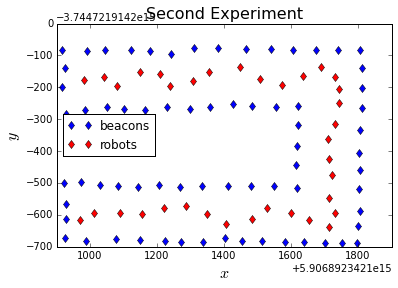

In [16]:
result = LevenbergMarquardt(beacons, robots, x, y)
beacons_x, robots_x, beacons_y, robots_y, ang = np.split(result.x, np.cumsum([beacons.max(), robots.max()] * 2))


plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('Second Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)

plt.show()

** Experiment three (task3.mat) - 6 points: **  This is another complex environment. On top of the complications from the previous experiment, your robot beacon identification system is now working imperfectly, so that every so often (say, in 3% cases), the robot would confuse the number of the beacon that it observes. You have to make your reconstruction algorithm robust to such mistakes.  Instruction: use non-linear optimization *scipy.optimize* in python (you get 2 points for any implementation that produces an accurate reconstruction). You are recommended to supply it with an analytically-computed gradient (+2 points). Use the option 'method=BFGS' to make python to use a quasi-Newton BFGS method, play with the number of iterations that are allowed ('options.maxiter') to see the effect; you can also try to provide the algorithm with the Hessian derived analytically. You get +2 points if your approach devised this way will work faster or comparable with quasi-Newton. 

**Output.** For each experiment, your pdf file should include:
*	A printout of the reconstruction: use e.g. scatter plots with different colors used for beacons and robots positions.
*	An explanation of what you have tried and what you have observed.
Of course, your code should be attached.


In [111]:
import scipy.io as sio

mat_contents = sio.loadmat('task3.mat')

beacons = mat_contents['beacons']
robots = mat_contents['robots']
x = mat_contents['x']
y = mat_contents['y']

#### 1.Levenberg - Marquardt

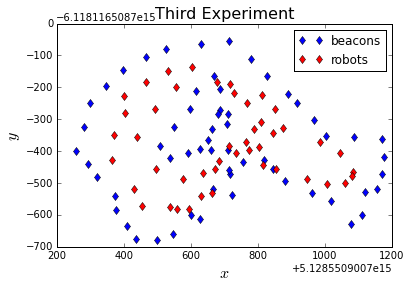

In [115]:
result = LevenbergMarquardt(beacons, robots, x, y)
beacons_x, robots_x, beacons_y, robots_y, ang = np.split(result.x, np.cumsum([beacons.max(), robots.max()] * 2))


plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('Third Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)

plt.show()

#### 2. Huber Robust loss function:

\begin{split}\text{huber}(\delta, r) = \begin{cases} \infty & \delta < 0  \\ \frac{1}{2}r^2 & 0 \le \delta, | r | \le \delta \\ \delta ( |r| - \frac{1}{2}\delta ) & \text{otherwise} \end{cases}\end{split}

##### Quasi-Newton method

In [150]:
def huber_derivative(a, gamma): 
    if (a < -gamma): 
        return -gamma 
    if (a > gamma): 
        return gamma 
    return a


def BFGS(beacons, robots, x, y, gamma, maxiter = None):
    
    nmb_robots = robots.max()
    nmb_angles = robots.max()
    nmb_beacons = beacons.max()
    nmb_measurements = len(x)
    
    
    robots = robots.ravel() - 1
    beacons = beacons.ravel() - 1
    
    A_r = np.zeros((nmb_measurements, nmb_robots))
    A_b = np.zeros((nmb_measurements, nmb_beacons))
    A_r[np.arange(nmb_measurements), robots] =  1 # we have 1 in gradient for robots
    A_b[np.arange(nmb_measurements), beacons] = -1 # we have -1 in gradient for beacons

    A = np.hstack((A_b, A_r))
    A = np.array(np.bmat([[A, np.zeros(A.shape)], [np.zeros(A.shape), A]]))
    v = np.linalg.lstsq(A, - np.vstack((x, y)))[0]

    x = x.ravel()
    y = y.ravel()

    initialization = np.hstack((v.ravel(), np.zeros(nmb_angles)))

    def fun(z):
        beacons_x, robots_x, beacons_y, robots_y, angles = np.split(z, np.cumsum([nmb_beacons, nmb_robots] * 2))
        func =  np.hstack((
                robots_x[robots] - beacons_x[beacons] + x * np.cos(angles[robots]) - y * np.sin(angles[robots]),
                robots_y[robots] - beacons_y[beacons]  + x * np.sin(angles[robots]) + y * np.cos(angles[robots])))
        return scipy.special.huber(gamma, func).sum()

    def jac(z):
        beacons_x, robots_x, beacons_y, robots_y, angles = np.split(z, np.cumsum([nmb_beacons, nmb_robots] * 2))
        A_a = np.zeros((A.shape[0], nmb_angles)) # derivatives for angles
        gradient = np.hstack((-x * np.sin(angles[robots]) - y * np.cos(angles[robots]),
                              x * np.cos(angles[robots]) - y * np.sin(angles[robots])))
        A_a[range(A_a.shape[0]), np.hstack((robots, robots))] = gradient.ravel()
        G = np.hstack((A, A_a))
        
        func =  np.hstack((
                robots_x[robots] - beacons_x[beacons] + x * np.cos(angles[robots]) - y * np.sin(angles[robots]),
                robots_y[robots] - beacons_y[beacons]  + x * np.sin(angles[robots]) + y * np.cos(angles[robots])))
        huber_derivative = func.clip(-gamma, gamma)
        
        return (huber_derivative.reshape(-1, 1) * G).sum(0)
    
    
    return scipy.optimize.minimize(fun, initialization, method='BFGS', jac=jac, options={'maxiter': maxiter})

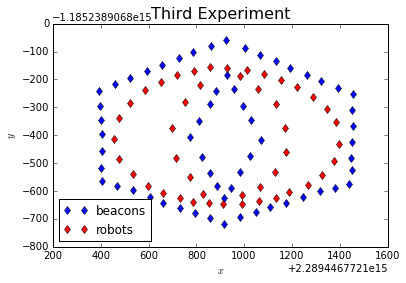

In [138]:
result = BFGS(beacons, robots, x, y, 0.5)
beacons_x, robots_x, beacons_y, robots_y, ang = np.split(result.x, np.cumsum([beacons.max(), robots.max()] * 2))


plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('Third Experiment', size=16)
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

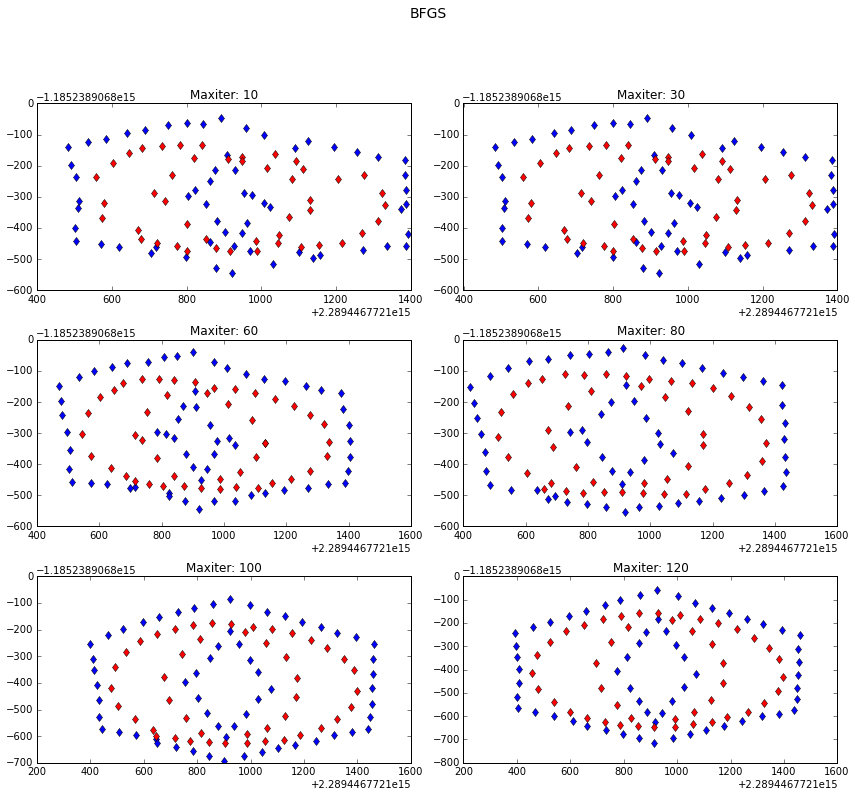

In [149]:
nmb_b = beacons.max()
nmb_r = robots.max()

mxtrs = [10, 30, 60, 80, 100, 120]
m = 3
n = 2
fig, ax = plt.subplots(m, n, figsize=(12, 10))
for i in range(m):
    for j in range(n):
        maxiter = mxtrs[n * i + j]
        result = BFGS(beacons, robots, x, y, 0.5, maxiter=maxiter)
        beacons_x, robots_x, beacons_y, robots_y,a = np.split(result.x, np.cumsum([nmb_b, nmb_r] * 2))
        ax[i, j].plot(beacons_x, beacons_y, 'db', label='beacons')
        ax[i, j].plot(robots_x, robots_y, 'dr', label='robots')

        ax[i, j].set_title('Maxiter: %d' % maxiter)

fig.suptitle('BFGS', fontsize = 14, y = 1.1)
fig.tight_layout()
plt.show()


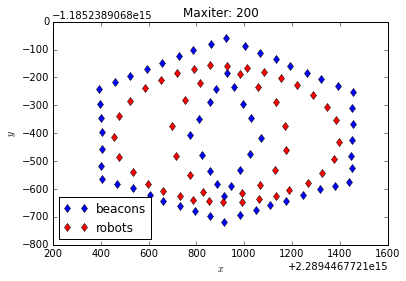

In [148]:
maxiter = 200
result = BFGS(beacons, robots, x, y, 0.5)
beacons_x, robots_x, beacons_y, robots_y, ang = np.split(result.x, np.cumsum([beacons.max(), robots.max()] * 2))


plt.plot(beacons_x, beacons_y, 'db', label='beacons')
plt.plot(robots_x, robots_y, 'dr', label='robots')
plt.title('Maxiter: %d' % maxiter)
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()